In [2]:
import numpy as np
import scipy.sparse as sparse
import math
import matplotlib.pyplot as plt
from mec import make_circle
import copy
from itertools import chain
from collections import Counter

In [3]:
def in_circle(point, circle):
    x, y = point
    cx, cy, r = circle
    return np.sqrt((x - cx)**2 + (y - cy)**2) <= r

In [71]:
m = 20
n = m**2

r = np.sqrt(2)*((m/2)**0.4)
deg_v = 4 # w_c. Every bit is in this many checks
deg_c = 5 # w_r. Every check has this many bits in it
num_checks = (n*deg_v)//deg_c
k = n - num_checks

vs = [deg_v for _ in range(n)]
qbts = [(x,y) for x in range(m) for y in range(m)]
pot_qbts = np.ones((num_checks, n))
ops = [[] for i in range(num_checks)]

while (np.count_nonzero(vs)):
    if (np.count_nonzero(pot_qbts)):
        c_ind = np.random.choice(np.where(pot_qbts.any(axis=1))[0])
    else:
        print("Failed")
        break

    # choose a v that is within the specified radius (from list of potential qbts)
    v_ind = np.random.choice(np.nonzero(pot_qbts[c_ind])[0])
    ops[c_ind].append(qbts[v_ind])
    
    if (len(ops[c_ind]) == deg_c):
        pot_qbts[c_ind, :] = 0
    else:
        pot_qbts[c_ind][v_ind] = 0

    # update potential qbts
    for pot_ind, pot in enumerate(pot_qbts[c_ind]):
        if (pot and (make_circle(ops[c_ind] + [qbts[pot_ind]])[2] > r)):
            pot_qbts[c_ind][pot_ind] = 0

    vs[v_ind] -= 1
    if (not vs[v_ind]):
        pot_qbts[:, v_ind] = 0

    print(sum(vs))

1599
1598
1597
1596
1595
1594
1593
1592
1591
1590
1589
1588
1587
1586
1585
1584
1583
1582
1581
1580
1579
1578
1577
1576
1575
1574
1573
1572
1571
1570
1569
1568
1567
1566
1565
1564
1563
1562
1561
1560
1559
1558
1557
1556
1555
1554
1553
1552
1551
1550
1549
1548
1547
1546
1545
1544
1543
1542
1541
1540
1539
1538
1537
1536
1535
1534
1533
1532
1531
1530
1529
1528
1527
1526
1525
1524
1523
1522
1521
1520
1519
1518
1517
1516
1515
1514
1513
1512
1511
1510
1509
1508
1507
1506
1505
1504
1503
1502
1501
1500
1499
1498
1497
1496
1495
1494
1493
1492
1491
1490
1489
1488
1487
1486
1485
1484
1483
1482
1481
1480
1479
1478
1477
1476
1475
1474
1473
1472
1471
1470
1469
1468
1467
1466
1465
1464
1463
1462
1461
1460
1459
1458
1457
1456
1455
1454
1453
1452
1451
1450
1449
1448
1447
1446
1445
1444
1443
1442
1441
1440
1439
1438
1437
1436
1435
1434
1433
1432
1431
1430
1429
1428
1427
1426
1425
1424
1423
1422
1421
1420
1419
1418
1417
1416
1415
1414
1413
1412
1411
1410
1409
1408
1407
1406
1405
1404
1403
1402
1401
1400


In [72]:
_ = []
for gen in ops:
    for qbt in gen:
        _.append(qbt)

qbt_counter = Counter(_ + qbts)
print(qbt_counter)

Counter({(2, 6): 5, (5, 6): 5, (1, 3): 5, (0, 7): 5, (0, 3): 5, (3, 15): 5, (7, 14): 5, (3, 14): 5, (4, 16): 5, (8, 13): 5, (5, 16): 5, (11, 14): 5, (10, 14): 5, (13, 15): 5, (13, 19): 5, (18, 18): 5, (17, 17): 5, (3, 19): 5, (9, 16): 5, (8, 16): 5, (10, 17): 5, (5, 19): 5, (9, 18): 5, (9, 15): 5, (13, 1): 5, (18, 3): 5, (13, 6): 5, (15, 5): 5, (17, 3): 5, (7, 9): 5, (5, 8): 5, (4, 13): 5, (9, 13): 5, (3, 13): 5, (11, 0): 5, (7, 5): 5, (6, 0): 5, (7, 4): 5, (11, 15): 5, (11, 16): 5, (14, 18): 5, (11, 19): 5, (11, 3): 5, (8, 2): 5, (5, 1): 5, (13, 17): 5, (11, 18): 5, (14, 13): 5, (13, 18): 5, (1, 7): 5, (0, 13): 5, (1, 11): 5, (0, 8): 5, (3, 7): 5, (1, 10): 5, (0, 6): 5, (6, 5): 5, (2, 4): 5, (7, 0): 5, (11, 4): 5, (8, 7): 5, (9, 2): 5, (10, 1): 5, (2, 3): 5, (8, 5): 5, (3, 0): 5, (5, 4): 5, (3, 1): 5, (19, 12): 5, (18, 17): 5, (17, 14): 5, (19, 17): 5, (16, 17): 5, (6, 10): 5, (6, 14): 5, (10, 12): 5, (4, 10): 5, (4, 9): 5, (6, 16): 5, (7, 16): 5, (5, 18): 5, (2, 16): 5, (14, 12): 5, 

In [73]:
print(len([op for op in ops if len(op) == deg_c]))
print(num_checks)

291
320


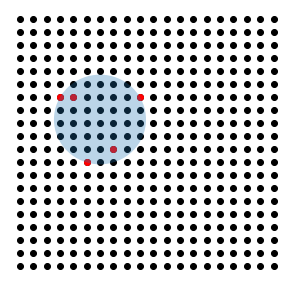

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

i = 7

# pot_qbt_inds = [qbts[j] for j in pot_qbts[i]]
xs, ys = zip(*qbts)
op_xs, op_ys = zip(*ops[i])
# pot_xs, pot_ys = zip(*pot_qbt_inds)

cir = make_circle(ops[i])
c = plt.Circle((cir[0], cir[1]), cir[2], alpha=0.3)
ax.scatter(xs, ys, c='k')
ax.scatter(op_xs, op_ys, c='r')
# ax.scatter(pot_xs, pot_ys, c='b')


ax.add_artist(c)
ax.axis('off')
plt.show()

In [63]:
for i in np.linspace(0, 1, 11):
    print(i, np.sqrt(2)*(m/2)**i)

0.0 1.4142135623730951
0.1 1.7803893913754452
0.2 2.241377447691299
0.30000000000000004 2.821727026320928
0.4 3.552343858581805
0.5 4.47213595499958
0.6000000000000001 5.630085598747348
0.7000000000000001 7.087857830839416
0.8 8.923084338428025
0.9 11.233497625229584
1.0 14.142135623730951


In [64]:
rs = [make_circle(op)[2] for op in ops]
print(np.mean(rs))

4.000960963324753
